In [41]:
from keras.applications import ResNet50V2
from keras.applications.resnet_v2 import preprocess_input
from keras.models import Model
from keras.layers import Input, Dropout, Dense, Embedding, MultiHeadAttention, LayerNormalization, Layer, Concatenate, add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import load_img
import tensorflow as tf
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from glob import glob
from matplotlib import pyplot as plt

# Process Captions
To process the captions, I make all of the text lowercase and remove characters that are not letters. I also add START and END tokens. I then tokenize the sequences.

In [42]:
df_captions = pd.read_csv('captions.txt')
df_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


I keep only the first description for each image.

In [43]:
df_captions = df_captions.drop_duplicates('image')

In [44]:
df_captions['caption'] = df_captions['caption'].apply(lambda x: 'START ' + ''.join([char for char in x if char.isalpha() or char == ' ']).strip().lower() + ' END')
df_captions['caption'] = df_captions['caption'].apply(lambda x: word_tokenize(x))
df_captions.head()

,image,caption
0,1000268201_693b08cb0e.jpg,"[START, a, child, in, a, pink, dress, is, clim..."
5,1001773457_577c3a7d70.jpg,"[START, a, black, dog, and, a, spotted, dog, a..."
10,1002674143_1b742ab4b8.jpg,"[START, a, little, girl, covered, in, paint, s..."
15,1003163366_44323f5815.jpg,"[START, a, man, lays, on, a, bench, while, his..."
20,1007129816_e794419615.jpg,"[START, a, man, in, an, orange, hat, starring,..."


# Separating Train and Test Images

Next, I separate the image file names into train and test sets.

In [45]:
img_ids = df_captions['image'].unique()
train_size = 0.9
test_idx = int(len(img_ids) * train_size)
train_ids = img_ids[:test_idx]
test_ids = img_ids[test_idx:]

# Vectorizing Captions

In [46]:
# Make a lookup dictionary to map tokens to integers
def flatten_corpus(corpus):
    flat_corpus = []
    for line in corpus:
        flat_corpus.extend(line)
    return flat_corpus

def make_tok2idx(corpus):
    flat_corpus = flatten_corpus(corpus)
    unique_toks = list(set(flat_corpus))
    tok2idx = {'PAD':0, 'UNK':1}
    tok_idx = 2
    for tok in unique_toks:
        tok2idx[tok] = tok_idx
        tok_idx += 1
    return tok2idx

df_train = df_captions.loc[df_captions['image'].isin(train_ids), 'caption']
tok2idx = make_tok2idx(df_train)
idx2tok = dict((value, key) for key, value in tok2idx.items())    

In [47]:
tok2idx.get('dog')

2505

In [48]:

def vectorize_seq(sequence):
    vector = []
    for tok in sequence:
        next_idx = tok2idx.get(tok)
        if next_idx is not None:
            vector.append(next_idx)
        else:
            vector.append(tok2idx['UNK'])
    return vector

def get_max_len(sequences):
    sequences = [vectorize_seq(seq) for seq in sequences]
    max_len = np.max([len(vector) for vector in sequences])
    return max_len

max_len = get_max_len(df_train)

# Image Feature Extraction
To extract features from images, I use a ResNet50V2 model with ImageNet weights.

In [49]:
target_size = (224, 224) # original resnet size

resnet = ResNet50V2(include_top=False, input_shape=target_size + (3,), pooling='max')
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

To save on memory, I will not load the images now. Rather, I will write a generator that will load samples as the models train.

In [50]:
def load_img_descriptions(img_ids, max_len=max_len):
    descriptions = df_captions.loc[df_captions['image'].isin(img_ids)]['caption'].values
    descriptions = [vectorize_seq(description) for description in descriptions]
    inputs = np.zeros((len(descriptions), max_len))
    targets = np.zeros((len(descriptions), max_len))
    
    for i, description in enumerate(descriptions):
        for j, tok in enumerate(description):
            if j < len(description) - 1: # exclude END from inputs
                inputs[i][j] = tok
            if j > 0: # targets = inputs shifted by 1
                targets[i][j-1] = tok
    return inputs, targets

In [51]:
def data_gen(img_ids, img_dir, batch_size):
    '''
    Yields data for the model for training: an input sequence, output sequence, and associated image.
    '''
    while True:
        num_samples = len(img_ids)
        start_idx = 0
        for i in range(0, num_samples, batch_size):
            
            # Get a batch of ids
            end_idx = start_idx + batch_size
            if end_idx >= num_samples:
                batch = img_ids[start_idx:]
            else:
                batch = img_ids[start_idx:end_idx]
            start_idx += batch_size
            
            # Load images
            img_locs = [img_dir+'/'+id for id in batch]
            images = np.asarray([np.asarray(load_img(img_loc, target_size=target_size)) for img_loc in img_locs])
            images = np.asarray([preprocess_input(img) for img in images])
            img_features = resnet.predict(images, verbose=0)
            
            # Get text sequences
            text_inputs, text_targets = load_img_descriptions(batch)
            

            yield (text_inputs, img_features), text_targets

# Positional Embeddings and Transformer Decoder
This section contains layers needed for the transformer and a layer to combine text and image features. The first is a positional embedding feature. Transformers have many benefits over RNNs, but they do not by themselves encode position. The positional embedding here is simple. The model learns embeddings both encode positional information and semantic information. The positional embeddings are an element-wise sum of those weights.

The transformer is the transformer decoder from [Attention is All You Need](https://arxiv.org/abs/1706.03762). While it does not affect the architecture of the transformer decoder, it should be noted that in the paper the transformer was used for machine translation in a sequence to sequence architecture, thus the decoder performed self-attention and attention between source and target language sequences. Here, the decoder only performs self-attention.

Finally, there is a custom addition layer.  Here, the image features are (batch_size, 2048), but transformer outputs are (batch_size, max_len, embed_dim). I project the image layers down to embed_dim with a dense layer, then pass those projections to the custom addition layer. This addition layer repeats the image feature projections and reshapes them to (batch_size, max_len, embed_dim), i.e. each batch has max_len image feature projections. The image features and transformer outputs can then be added together.

This custom addittion layer is simply an extrapolation from the process in [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137). In [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137), addition is described as the best way to combine image and text features. However in that paper, they use an RNN where I use the transformer decoder (in addition to performing a slightly diifferent training task, discussed below). Thus in that application addition is trivial - the image features are of some fixed size, say (1, feature_size), so if the RNN's hidden vectors are made to be the same size, the final RNN hidden statee can be added to the image features.

In [52]:
class PositionalEmbedding(Layer):
    def __init__(self, seq_len, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.tok_embedding = Embedding(vocab_size, embed_dim)
        self.pos_embedding = Embedding(seq_len, embed_dim)
        self.seq_len = seq_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        
    def call(self, x):
        tok_embeds = self.tok_embedding(x)
        
        positions = tf.range(0, tf.shape(x)[-1])
        pos_embeds = self.pos_embedding(positions)
        return tf.add(pos_embeds, tok_embeds)
    
    def compute_mask(self, inputs, mask=None):
        mask = tf.math.not_equal(inputs, 0)
        return mask
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'seq_len': self.seq_len,
                'vocab_size': self.vocab_size,
                'embed_dim': self.embed_dim
            }
        )
        return config

In [53]:
class TransformerDecoder(Layer):
    def __init__(self, num_heads, embed_dim, dense_units, dropout=0.0, **kwargs):
        '''
        Transformer decoder using Vaswani attention.
        Parameters: num_heads, number of heads for multi-head attention
                    embed_dim, embedding dimension of input sequences
                    dense_units, number of units in non-linear dense layer
        '''
        super().__init__(**kwargs)
        self.self_attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout)
        self.dense = Dense(dense_units, activation='relu')
        self.linear = Dense(embed_dim)
        self.self_attention_layernorm = LayerNormalization()
        self.attention_layernorm = LayerNormalization()
        self.dense_layernorm = LayerNormalization()
        self.num_heads = num_heads
        self.key_dim = embed_dim # Note any key's last dimension should be the embed size, else error when dense layer project
        self.dense_units = dense_units
        self.supports_masking = True
        self.dropout_rate = dropout
        
    def call(self, query, values, mask=None, track_weights=False):
        '''
        Forward pass for transformer decoder using Vaswani attention
        '''
        # Make causal masks
        causal_mask = self.make_causal_mask(query)
        
        # Make padding mask
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            padding_mask = tf.minimum(padding_mask, causal_mask) # Masks both "future" targets the model shouldn't see and padding tokens
        
        # Self-attention
        self_attention_output = self.self_attention(query, query, attention_mask=causal_mask)
        normed_self_attention_output = self.self_attention_layernorm(values + self_attention_output)
        
        # Attention over encoder inputs
        attention_output = self.attention(normed_self_attention_output, values, attention_mask=padding_mask)
        normed_attention_outputs = self.attention_layernorm(attention_output + normed_self_attention_output)
        
        # Projections wiith dense layers
        x = self.dense(normed_attention_outputs)
        x = self.linear(x)
        decoder_outputs = self.dense_layernorm(x + normed_attention_outputs)
        
        return decoder_outputs
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'num_heads': self.num_heads,
                'key_dem': self.key_dim,
                'dense_units': self.dense_units,
                'dropout_rate': self.dropout_rate
            }
        )
        return config
        
    def make_causal_mask(self, inputs): # (don't forget to modify to self, input when implementing)
        '''
        Makes a mask to prevent attention layers from seeing future characters during training
        '''
        inputs_shape = tf.shape(inputs) # using this as opposed to .shape handles the None batch size in placeholder tensors
        batch_size, seq_len = inputs_shape[0], inputs_shape[1]
        a = tf.range(seq_len)[:, tf.newaxis]
        b = tf.range(seq_len)

        causal_mask = tf.cast(a >= b, 'int32') # creates a (seq_len, seq_len) LT matrix with ones on and below diag

        # Stack batch_size causal masks on top of each other
        causal_mask = tf.reshape(causal_mask, (1, seq_len, seq_len))
        mult = tf.concat([tf.expand_dims(batch_size, -1), tf.constant([1,1], dtype='int32')], axis=0)
        causal_mask = tf.tile(causal_mask, mult)
        return causal_mask

In [54]:
class AddImageToText(Layer):
    '''
    Adds the feature from an image to the output of a transformer called on a text sequence.
    '''
    def __init__(self, seq_len, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.seq_len = seq_len
        self.embed_dim = embed_dim
        
    def call(self, img, text_sequence):
        img = tf.repeat(img, self.seq_len, axis=0)
        img = tf.reshape(img, shape=(-1, self.seq_len, self.embed_dim))
        sum = tf.add(img, text_sequence)
        return sum
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
                'embed_dim': self.embed_dim,
                'seq_len': self.seq_len
            }
        )
        return config

# Build Model
The model architecture is very similar to an encoder-decoder architecture, but with separate "encoders" for text and image data. The encoder for the image data is just the pretrained resnet model - this is called in the data generator. The encoder for the text data is a transformer. Since transformers have no concept of sequence order, positional embeddings are used. The encoded data is combined and fed into the decoder, which is a simple classification model. The outputs are sequences of distributions calculated using a softmax function. In this sense, the model is roughly a sequence to sequence model.

This model is similar to the injection model described in the paper [Where to Put the Image in an Image Captioning Model](https://arxiv.org/abs/1703.09137) with two notable exceptions. First, the paper uses an RNN as the text encoder, while I use a transformer. Second, my model is trained an a pseudo-sequence-to-sequence fashion in the sense that inputs are a sequence and outputs are the sequence shifted by one. This is a more natural use of a transformer than the training method described in the paper, in my opinion.

In [55]:
num_heads = 4
transformer_dense_units = 512
transformer_dropout_rate = 0.6
dropout_rate = 0.6
embed_dim = 100
vocab_size = len(tok2idx)

In [56]:

# Text encoder
text_inputs = Input(shape=(None,), name='text_inputs')
text_embedding_layer = PositionalEmbedding(seq_len=max_len, vocab_size=vocab_size, embed_dim=embed_dim, name='text_embeds')
text_embeds = text_embedding_layer(text_inputs)
text_transformer = TransformerDecoder(num_heads=num_heads, embed_dim=embed_dim, dense_units=transformer_dense_units, dropout=transformer_dropout_rate)
text_encoded = text_transformer(text_embeds, text_embeds)


# Image_encoder
image_inputs = Input(shape=(2048,), name='image_inputs')
image_encoded = Dense(embed_dim)(image_inputs)

# Combine encoded data
encoded = AddImageToText(seq_len=max_len, embed_dim=embed_dim)(image_encoded, text_encoded)

# "Decoder"
x = Dense(1024, activation='relu')(encoded)
x = Dropout(dropout_rate)(x)
x = Dense(512)(x)
outputs = Dense(vocab_size, activation='softmax')(x)

model = Model([text_inputs, image_inputs], outputs)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_inputs (InputLayer)       [(None, None)]       0           []                               
                                                                                                  
 image_inputs (InputLayer)      [(None, 2048)]       0           []                               
                                                                                                  
 text_embeds (PositionalEmbeddi  (None, None, 100)   430900      ['text_inputs[0][0]']            
 ng)                                                                                              
                                                                                                  
 dense_18 (Dense)               (None, 100)          204900      ['image_inputs[0][0]']     

In [57]:
batch_size = 32       
train_gen = data_gen(train_ids, 'images', batch_size=batch_size)
val_gen = data_gen(test_ids[:len(test_ids)//2], 'images', batch_size=len(test_ids)//2)
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(train_gen, steps_per_epoch=len(train_ids)//batch_size, validation_data=val_gen, validation_steps=(len(test_ids)//2)//batch_size, epochs=50)

Epoch 1/50
227/227 [==============================] - 86s 377ms/step - loss: 2.2367 - accuracy: 0.6751 - val_loss: 1.7278 - val_accuracy: 0.7090
Epoch 2/50
227/227 [==============================] - 54s 240ms/step - loss: 1.7666 - accuracy: 0.7049 - val_loss: 1.7661 - val_accuracy: 0.7028
Epoch 3/50
227/227 [==============================] - 108s 478ms/step - loss: 1.5153 - accuracy: 0.7294 - val_loss: 1.5503 - val_accuracy: 0.7371
Epoch 4/50
227/227 [==============================] - 110s 485ms/step - loss: 1.3799 - accuracy: 0.7402 - val_loss: 1.5655 - val_accuracy: 0.7471
Epoch 5/50
227/227 [==============================] - 99s 440ms/step - loss: 1.3397 - accuracy: 0.7438 - val_loss: 1.5467 - val_accuracy: 0.7415
Epoch 6/50
227/227 [==============================] - 143s 633ms/step - loss: 1.2732 - accuracy: 0.7518 - val_loss: 1.6317 - val_accuracy: 0.7454
Epoch 7/50
 65/227 [=======>......................] - ETA: 1:13 - loss: 1.2472 - accuracy: 0.7528

KeyboardInterrupt: 

# Inference

In [ ]:
def vec_to_tok(vector):
    return [idx2tok[tok] for tok in vector]

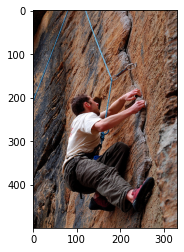

'a man in a green shirt is climbing a stone wall'

In [ ]:
def get_caption(img_path):
    caption_string = 'START'
    image = np.asarray(load_img(img_path, target_size=target_size))
    image = np.expand_dims(preprocess_input(image), 0)
    image_features = resnet(image)
    for i in range(max_len):
        caption_idxs = vectorize_seq(caption_string.split(' '))
        vectorized_sentence = np.zeros((1, max_len))
        for i, idx in enumerate(caption_idxs):
            vectorized_sentence[0][i] = idx
        
        # Get next token index
        prediction = model([vectorized_sentence, image_features])
        next_tok_idx = np.argmax(prediction[0, i, :])
        
        # Update string
        next_tok = idx2tok[next_tok_idx]
        caption_string += ' ' + next_tok
        
        # Break if END predicted
        if next_tok == 'END':
            break
        
    if caption_string.endswith('END'):
        return ' '.join(caption_string.split(' ')[1:-1])
    else:
        return ' '.join(caption_string.split(' ')[1:])
    

def plot_img(img_dir, img_id):
    img_loc = img_dir+'/'+img_id
    img = load_img(img_loc)
    plt.imshow(img)
    plt.show()
    return img_loc
    
loc = plot_img('images', train_ids[103])
get_caption(loc)